In [1]:
!pip install roboflow
from roboflow import Roboflow
rf = Roboflow(api_key="1b5aH9qlySyUZJX3r5VI")
project = rf.workspace("microsoft").project("coco-dataset-vdnr1")
version = project.version(26)
dataset = version.download("yolov11")

loading Roboflow workspace...
loading Roboflow project...


In [2]:
import os
import glob
import shutil
import yaml
import random
from tqdm import tqdm
from collections import defaultdict

# --- CONFIGURATION ---
SOURCE_DIR = dataset.location   # The path from your Roboflow download
DEST_DIR = "balanced_dataset"   # New folder name
TARGET_TOTAL = 5000             # Total images desired
SPLIT = "train"                 # We usually only reduce the training set

# 1. Setup Directories
if os.path.exists(DEST_DIR):
    shutil.rmtree(DEST_DIR)

for sub in ['images', 'labels']:
    os.makedirs(os.path.join(DEST_DIR, SPLIT, sub), exist_ok=True)

# Copy data.yaml
shutil.copy(os.path.join(SOURCE_DIR, "data.yaml"), os.path.join(DEST_DIR, "data.yaml"))

# Load Class Info
with open(os.path.join(SOURCE_DIR, "data.yaml"), 'r') as f:
    data_info = yaml.safe_load(f)
    num_classes = data_info['nc']
    class_names = data_info['names']

# Calculate Target per Class (e.g., 5000 / 80 = 62 images per class)
target_per_class = TARGET_TOTAL // num_classes
print(f"Aiming for ~{target_per_class} images per class (Total: {TARGET_TOTAL})")

# 2. Scan All Labels
print("Scanning dataset labels...")
label_files = glob.glob(os.path.join(SOURCE_DIR, SPLIT, "labels", "*.txt"))

# Map: class_id -> list of file paths
class_to_files = defaultdict(list)
# Map: file_path -> list of classes in that file
file_to_classes = {}

for l_path in tqdm(label_files):
    with open(l_path, 'r') as f:
        # Get unique classes in this image
        classes_in_img = set()
        for line in f:
            classes_in_img.add(int(line.split()[0]))

        file_to_classes[l_path] = list(classes_in_img)

        for c in classes_in_img:
            class_to_files[c].append(l_path)

# 3. Intelligent Selection (Rare Classes First)
selected_files = set()
current_class_counts = defaultdict(int)

# Sort classes by rarity (fewer images = rarer)
sorted_classes = sorted(range(num_classes), key=lambda k: len(class_to_files[k]))

print("Selecting balanced images...")

# Pass 1: Try to fill quota for each class (starting with rarest)
for cls_id in sorted_classes:
    available_files = class_to_files[cls_id]
    random.shuffle(available_files) # Shuffle for randomness

    for l_path in available_files:
        # If we already have enough for this class, skip
        if current_class_counts[cls_id] >= target_per_class:
            break

        # If file already selected, just verify counts (skip adding)
        if l_path in selected_files:
            continue

        # Select this file
        selected_files.add(l_path)

        # Update counts for ALL classes in this image
        for c in file_to_classes[l_path]:
            current_class_counts[c] += 1

# Pass 2: If we are under 5000, fill with random remaining images
if len(selected_files) < TARGET_TOTAL:
    print(f"Quota filled. Current count: {len(selected_files)}. Filling to {TARGET_TOTAL}...")
    remaining_files = [f for f in label_files if f not in selected_files]
    random.shuffle(remaining_files)

    needed = TARGET_TOTAL - len(selected_files)
    selected_files.update(remaining_files[:needed])

# 4. Copy Files
print(f"Copying {len(selected_files)} images to '{DEST_DIR}'...")
for l_path in tqdm(selected_files):
    # Derive paths
    basename = os.path.basename(l_path)
    img_name_jpg = basename.replace(".txt", ".jpg")
    img_name_png = basename.replace(".txt", ".png") # Check png too

    # Source Paths
    src_lbl = l_path
    src_img_jpg = os.path.join(SOURCE_DIR, SPLIT, "images", img_name_jpg)
    src_img_png = os.path.join(SOURCE_DIR, SPLIT, "images", img_name_png)

    # Destination Paths
    dest_lbl = os.path.join(DEST_DIR, SPLIT, "labels", basename)
    dest_img = os.path.join(DEST_DIR, SPLIT, "images", img_name_jpg)

    # Copy Label
    shutil.copy(src_lbl, dest_lbl)

    # Copy Image (Check extension)
    if os.path.exists(src_img_jpg):
        shutil.copy(src_img_jpg, dest_img)
    elif os.path.exists(src_img_png):
         shutil.copy(src_img_png, dest_img.replace(".jpg", ".png"))

print("\n✅ Dataset reduced successfully!")
print(f"New dataset location: {os.path.abspath(DEST_DIR)}")

Aiming for ~64 images per class (Total: 5000)
Scanning dataset labels...


100%|██████████| 5/5 [00:00<00:00, 5770.92it/s]


Selecting balanced images...
Quota filled. Current count: 5. Filling to 5000...
Copying 5 images to 'balanced_dataset'...


100%|██████████| 5/5 [00:00<00:00, 2271.37it/s]


✅ Dataset reduced successfully!
New dataset location: /content/balanced_dataset


In [3]:
import os
import glob
import shutil
import yaml
import random
import math
from tqdm import tqdm
from collections import defaultdict

# --- CONFIGURATION ---
SOURCE_DIR = dataset.location   # Path to original large dataset
DEST_DIR = "balanced_dataset"   # New folder name
TARGET_TOTAL = 5000             # Total size of the new dataset
SOURCE_SPLIT = "train"          # We pull images from the original 'train' folder

# Split Ratios
TRAIN_RATIO = 0.8
VAL_RATIO = 0.1
TEST_RATIO = 0.1

# 1. Setup Directories
if os.path.exists(DEST_DIR):
    shutil.rmtree(DEST_DIR)

# Create train, val, test subfolders
for split in ['train', 'val', 'test']:
    os.makedirs(os.path.join(DEST_DIR, split, 'images'), exist_ok=True)
    os.makedirs(os.path.join(DEST_DIR, split, 'labels'), exist_ok=True)

# Copy and Update data.yaml
yaml_src = os.path.join(SOURCE_DIR, "data.yaml")
yaml_dst = os.path.join(DEST_DIR, "data.yaml")

# We read the original yaml to get class names
with open(yaml_src, 'r') as f:
    data_info = yaml.safe_load(f)
    num_classes = data_info['nc']
    class_names = data_info['names']

# Save new yaml pointing to local folders
# YOLO automatically finds train/val/test if they are in the same folder as data.yaml
new_yaml_data = {
    'path': os.path.abspath(DEST_DIR), # Absolute path is safer
    'train': 'train/images',
    'val': 'val/images',
    'test': 'test/images',
    'nc': num_classes,
    'names': class_names
}

with open(yaml_dst, 'w') as f:
    yaml.dump(new_yaml_data, f)


# --- SELECTION LOGIC (Same as before) ---

# Calculate Target per Class
target_per_class = TARGET_TOTAL // num_classes
print(f"Aiming for ~{target_per_class} images per class (Total: {TARGET_TOTAL})")

print("Scanning source labels...")
label_files = glob.glob(os.path.join(SOURCE_DIR, SOURCE_SPLIT, "labels", "*.txt"))

# Map: class_id -> list of file paths
class_to_files = defaultdict(list)
file_to_classes = {}

for l_path in tqdm(label_files):
    with open(l_path, 'r') as f:
        classes_in_img = set()
        for line in f:
            try:
                classes_in_img.add(int(line.split()[0]))
            except:
                pass # skip bad lines

        file_to_classes[l_path] = list(classes_in_img)
        for c in classes_in_img:
            class_to_files[c].append(l_path)

selected_files = set()
current_class_counts = defaultdict(int)
sorted_classes = sorted(range(num_classes), key=lambda k: len(class_to_files[k]))

print("Selecting balanced images...")

# Pass 1: Rare classes first
for cls_id in sorted_classes:
    available_files = class_to_files[cls_id]
    random.shuffle(available_files)

    for l_path in available_files:
        if current_class_counts[cls_id] >= target_per_class:
            break
        if l_path in selected_files:
            continue

        selected_files.add(l_path)
        for c in file_to_classes.get(l_path, []):
            current_class_counts[c] += 1

# Pass 2: Fill remainder
if len(selected_files) < TARGET_TOTAL:
    print(f"Quota filled. Current count: {len(selected_files)}. Filling to {TARGET_TOTAL}...")
    remaining_files = [f for f in label_files if f not in selected_files]
    random.shuffle(remaining_files)
    selected_files.update(remaining_files[:TARGET_TOTAL - len(selected_files)])

# --- SPLIT LOGIC (NEW) ---

print(f"Splitting {len(selected_files)} images into Train/Val/Test...")

# Convert set to list and shuffle
all_files = list(selected_files)
random.shuffle(all_files)

# Calculate indices
n_total = len(all_files)
n_train = int(n_total * TRAIN_RATIO)
n_val = int(n_total * VAL_RATIO)
# n_test is the rest

train_files = all_files[:n_train]
val_files = all_files[n_train:n_train + n_val]
test_files = all_files[n_train + n_val:]

print(f"Counts -> Train: {len(train_files)}, Val: {len(val_files)}, Test: {len(test_files)}")

# Helper function to copy
def copy_set(file_list, split_name):
    print(f"Copying to {split_name}...")
    for l_path in tqdm(file_list):
        basename = os.path.basename(l_path)
        img_name_jpg = basename.replace(".txt", ".jpg")
        img_name_png = basename.replace(".txt", ".png")

        # Source Image Path
        src_img_jpg = os.path.join(SOURCE_DIR, SOURCE_SPLIT, "images", img_name_jpg)
        src_img_png = os.path.join(SOURCE_DIR, SOURCE_SPLIT, "images", img_name_png)

        # Destination Paths
        dest_lbl = os.path.join(DEST_DIR, split_name, "labels", basename)
        dest_img = os.path.join(DEST_DIR, split_name, "images", img_name_jpg) # Default to jpg name

        # Copy Label
        shutil.copy(l_path, dest_lbl)

        # Copy Image
        if os.path.exists(src_img_jpg):
            shutil.copy(src_img_jpg, dest_img)
        elif os.path.exists(src_img_png):
            # If png, make sure dest has .png extension
            shutil.copy(src_img_png, dest_img.replace(".jpg", ".png"))

# Execute Copies
copy_set(train_files, 'train')
copy_set(val_files, 'val')
copy_set(test_files, 'test')

print(f"\n✅ Balanced Dataset Generated at: {os.path.abspath(DEST_DIR)}")
print("You can now train using 'balanced_dataset/data.yaml'")

Aiming for ~64 images per class (Total: 5000)
Scanning source labels...


100%|██████████| 5/5 [00:00<00:00, 5344.42it/s]


Selecting balanced images...
Quota filled. Current count: 5. Filling to 5000...
Splitting 5 images into Train/Val/Test...
Counts -> Train: 4, Val: 0, Test: 1
Copying to train...


100%|██████████| 4/4 [00:00<00:00, 1479.86it/s]


Copying to val...


0it [00:00, ?it/s]


Copying to test...


100%|██████████| 1/1 [00:00<00:00, 2125.85it/s]


✅ Balanced Dataset Generated at: /content/balanced_dataset
You can now train using 'balanced_dataset/data.yaml'


Calculating class distribution...


Processing label files: 100%|██████████| 4/4 [00:00<00:00, 9098.27it/s]


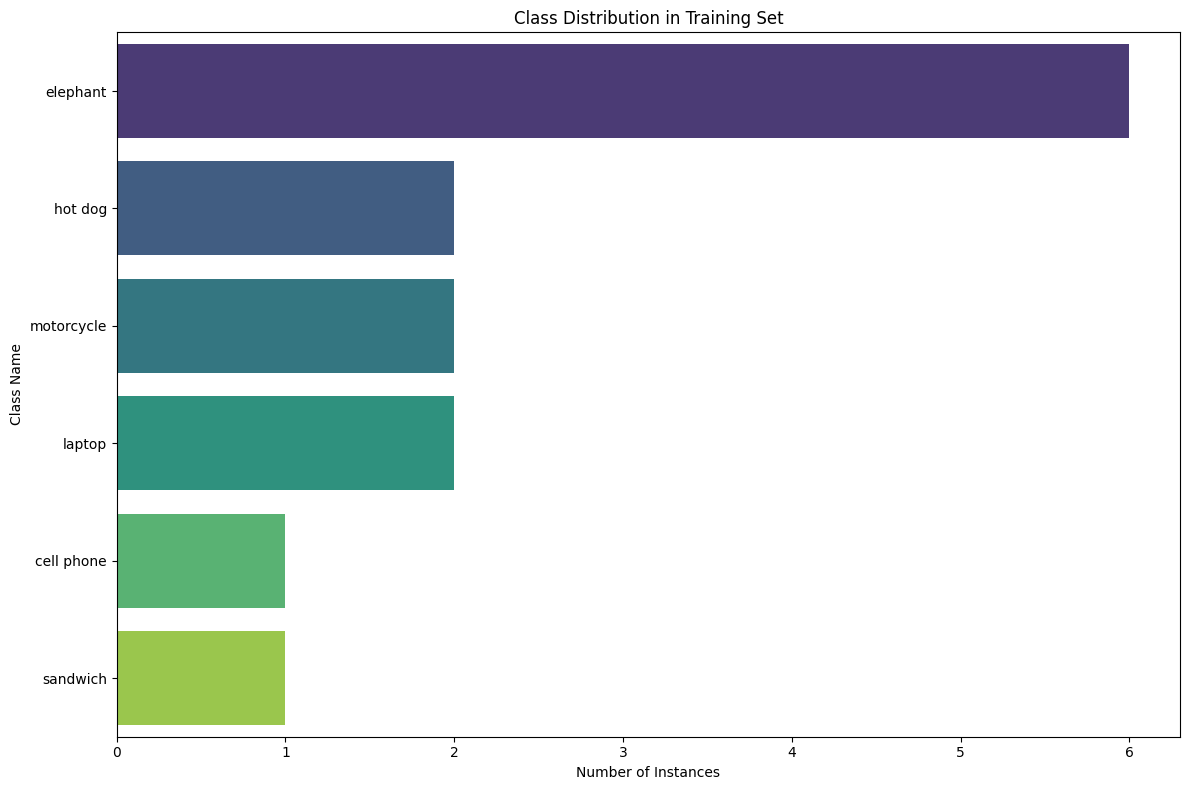

Sample Images:


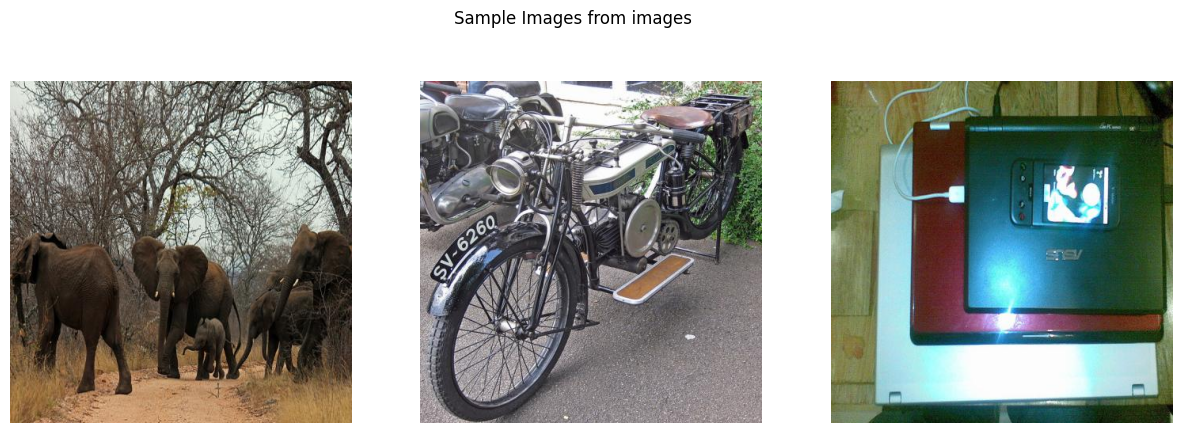

In [4]:
import cv2 # Import OpenCV
import glob # Ensure glob is imported if not already
import pandas as pd # Ensure pandas is imported
import matplotlib.pyplot as plt # Ensure matplotlib is imported
import seaborn as sns # Ensure seaborn is imported
import os
import yaml # For reading data.yaml
from collections import defaultdict # For counting classes
from tqdm import tqdm # For progress bar

# --- CONFIGURATION (Copied and updated to be self-contained for analysis) ---
DATASET_DIR = "balanced_dataset"  # Your new balanced dataset
SPLIT = "train"                 # Analyze the training split

# Paths
images_dir = os.path.join(DATASET_DIR, SPLIT, "images")
labels_dir = os.path.join(DATASET_DIR, SPLIT, "labels")
yaml_path = os.path.join(DATASET_DIR, "data.yaml")

# Load Class Names
class_names = []
if os.path.exists(yaml_path):
    with open(yaml_path, 'r') as f:
        data_yaml = yaml.safe_load(f)
        class_names = data_yaml.get('names', [])
else:
    print(f"Warning: data.yaml not found at {yaml_path}. Class names may be incorrect.")

# 3. Visualize Class Distribution
print("Calculating class distribution...")
train_counts = defaultdict(int)
label_files = glob.glob(os.path.join(labels_dir, "*.txt"))

for label_file in tqdm(label_files, desc="Processing label files"):
    with open(label_file, 'r') as f:
        for line in f:
            parts = line.strip().split()
            if parts:
                try:
                    class_id = int(parts[0])
                    train_counts[class_id] += 1
                except ValueError:
                    # Handle cases where the first part is not an integer
                    pass

# Prepare data for plotting
plot_data = []
for class_id, count in sorted(train_counts.items()):
    if class_id < len(class_names):
        plot_data.append({'Class': class_names[class_id], 'Count': count})
    else:
        plot_data.append({'Class': f"Unknown_Class_{class_id}", 'Count': count})

df = pd.DataFrame(plot_data)

if not df.empty:
    # Sort by count for better visualization
    df = df.sort_values(by='Count', ascending=False)

    plt.figure(figsize=(12, 8)) # Increased figure size for better readability
    sns.barplot(data=df, x='Count', y='Class', hue='Class', palette='viridis', legend=False)
    plt.title('Class Distribution in Training Set')
    plt.xlabel('Number of Instances')
    plt.ylabel('Class Name')
    plt.tight_layout()
    plt.show()
else:
    print("No class data to display.")


# 4. Preview Sample Images
def plot_samples(img_path, num_samples=3):
    img_files = glob.glob(os.path.join(img_path, "*.jpg")) # Get all jpg images
    if not img_files:
        img_files = glob.glob(os.path.join(img_path, "*.png")) # Also check for png

    if not img_files:
        print(f"No images found in {img_path}")
        return

    # Select a random subset of images if there are more than num_samples
    if len(img_files) > num_samples:
        selected_img_files = random.sample(img_files, num_samples)
    else:
        selected_img_files = img_files

    plt.figure(figsize=(15, 5))
    for i, img_file in enumerate(selected_img_files):
        img = cv2.imread(img_file)
        if img is not None:
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            plt.subplot(1, num_samples, i+1)
            plt.imshow(img)
            plt.axis('off')
        else:
            print(f"Could not load image: {img_file}")
    plt.suptitle(f"Sample Images from {os.path.basename(img_path)}")
    plt.show()

print("Sample Images:")
# Use images_dir from the balanced dataset
plot_samples(images_dir)

In [5]:
import os
import glob
import random
import yaml
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from tqdm import tqdm  # For progress bars

# --- UPDATE CONFIGURATION HERE ---
DATASET_DIR = "balanced_dataset"  # CHANGED: Points to your new balanced folder
SPLIT = "train"                 # We are analyzing the reduced training set

# Paths
images_dir = os.path.join(DATASET_DIR, SPLIT, "images")
labels_dir = os.path.join(DATASET_DIR, SPLIT, "labels")
yaml_path = os.path.join(DATASET_DIR, "data.yaml")

# Load Class Names
if os.path.exists(yaml_path):
    with open(yaml_path, 'r') as f:
        data_yaml = yaml.safe_load(f)
        class_names = data_yaml.get('names', [])
else:
    class_names = {} # Fallback if no yaml found

print(f"Analyzing dataset at: {images_dir}")

Analyzing dataset at: balanced_dataset/train/images


In [18]:
import os
import glob
import shutil
import yaml
import random
from tqdm import tqdm
from collections import defaultdict
from pathlib import Path

# --- DYNAMIC CONFIGURATION ---
# This line automatically finds the folder Roboflow just downloaded
possible_dirs = [d for d in os.listdir('.') if os.path.isdir(d) and 'COCO' in d]
SOURCE_DIR = possible_dirs[0] if possible_dirs else "COCO-Dataset-2"

DEST_DIR = "balanced_dataset"
TARGET_TOTAL = 5000
SOURCE_SPLIT = "train" # The subfolder where original data sits

print(f"📂 Detected Source Directory: {SOURCE_DIR}")

# 1. Setup Directories
if os.path.exists(DEST_DIR):
    shutil.rmtree(DEST_DIR)

for split in ['train', 'val', 'test']:
    os.makedirs(os.path.join(DEST_DIR, split, 'images'), exist_ok=True)
    os.makedirs(os.path.join(DEST_DIR, split, 'labels'), exist_ok=True)

# 2. Load YAML & Handle Path Errors
yaml_src = os.path.join(SOURCE_DIR, "data.yaml")
if not os.path.exists(yaml_src):
    # Try looking one level deeper if Roboflow nested it
    nested_yaml = glob.glob(f"{SOURCE_DIR}/**/data.yaml", recursive=True)
    if nested_yaml:
        yaml_src = nested_yaml[0]
        SOURCE_DIR = os.path.dirname(yaml_src)
        print(f"🔄 Corrected Source Path: {SOURCE_DIR}")
    else:
        print(f"❌ Critical Error: data.yaml not found in {SOURCE_DIR}")
        exit()

with open(yaml_src, 'r') as f:
    data_info = yaml.safe_load(f)
    num_classes = data_info['nc']
    class_names = data_info['names']

# 3. Scanning Labels
print("🔍 Scanning labels for balancing...")
label_files = glob.glob(os.path.join(SOURCE_DIR, SOURCE_SPLIT, "labels", "*.txt"))

if not label_files:
    print(f"❌ Error: No labels found in {os.path.join(SOURCE_DIR, SOURCE_SPLIT, 'labels')}")
    print("Check your folder structure. It might be SOURCE_DIR/labels instead of SOURCE_DIR/train/labels.")
    exit()

class_to_files = defaultdict(list)
file_to_classes = {}

for l_path in tqdm(label_files, desc="Parsing"):
    with open(l_path, 'r') as f:
        classes_in_img = {int(line.split()[0]) for line in f if line.strip()}
        file_to_classes[l_path] = list(classes_in_img)
        for c in classes_in_img:
            class_to_files[c].append(l_path)

# 4. Balancing Logic
target_per_class = TARGET_TOTAL // num_classes
selected_files = set()
current_counts = defaultdict(int)

# Sort by rarity
for cls_id in sorted(range(num_classes), key=lambda k: len(class_to_files[k])):
    available = class_to_files[cls_id]
    random.shuffle(available)
    for l_path in available:
        if current_counts[cls_id] >= target_per_class: break
        if l_path not in selected_files:
            selected_files.add(l_path)
            for c in file_to_classes[l_path]:
                current_counts[c] += 1

# Fill remainder
if len(selected_files) < TARGET_TOTAL:
    rem = [f for f in label_files if f not in selected_files]
    random.shuffle(rem)
    selected_files.update(rem[:TARGET_TOTAL - len(selected_files)])

# 5. Split and FAST Copy
all_files = list(selected_files)
random.shuffle(all_files)

splits = {
    'train': all_files[:int(len(all_files)*0.8)],
    'val': all_files[int(len(all_files)*0.8):int(len(all_files)*0.9)],
    'test': all_files[int(len(all_files)*0.9):]
}

def fast_copy(file_list, split_name):
    print(f"🚀 Processing {split_name} split...")
    for l_path in tqdm(file_list):
        fname = os.path.basename(l_path)
        basename = os.path.splitext(fname)[0]

        # Label
        shutil.copy2(l_path, os.path.join(DEST_DIR, split_name, 'labels', fname))

        # Image (Checks multiple extensions)
        img_found = False
        for ext in ['.jpg', '.png', '.jpeg', '.JPG']:
            img_src = os.path.join(SOURCE_DIR, SOURCE_SPLIT, "images", basename + ext)
            if os.path.exists(img_src):
                shutil.copy2(img_src, os.path.join(DEST_DIR, split_name, 'images', basename + ext))
                img_found = True
                break

for name, files in splits.items():
    fast_copy(files, name)

# 6. Save new YAML
new_yaml = {
    'path': os.path.abspath(DEST_DIR),
    'train': 'train/images',
    'nc': num_classes,
    'names': class_names
}

# Always include a 'val' key. If val split is empty, point it to train images.
if splits['val']:
    new_yaml['val'] = 'val/images'
else:
    new_yaml['val'] = 'train/images' # Point val to train if val split is empty
    print("⚠️ Warning: Validation set is empty. Pointing 'val' to 'train' in data.yaml to prevent Ultralytics errors.")

if splits['test']:
    new_yaml['test'] = 'test/images'
else:
    print("⚠️ Warning: Test set is empty. It will not be included in data.yaml.")

with open(os.path.join(DEST_DIR, "data.yaml"), 'w') as f:
    yaml.dump(new_yaml, f)

print(f"\n✅ SUCCESS! Dataset generated at: {os.path.abspath(DEST_DIR)}")

📂 Detected Source Directory: COCO-Dataset-26
🔍 Scanning labels for balancing...


Parsing: 100%|██████████| 5/5 [00:00<00:00, 3603.35it/s]


🚀 Processing train split...


100%|██████████| 4/4 [00:00<00:00, 1754.57it/s]


🚀 Processing val split...


0it [00:00, ?it/s]


🚀 Processing test split...


100%|██████████| 1/1 [00:00<00:00, 904.14it/s]

⚠️ Warning: Validation set is empty. Pointing 'val' to 'train' in data.yaml to prevent Ultralytics errors.

✅ SUCCESS! Dataset generated at: /content/balanced_dataset


Analyzing dataset at: balanced_dataset/train/images
Analyzing image sizes...


100%|██████████| 4/4 [00:00<00:00, 1246.82it/s]


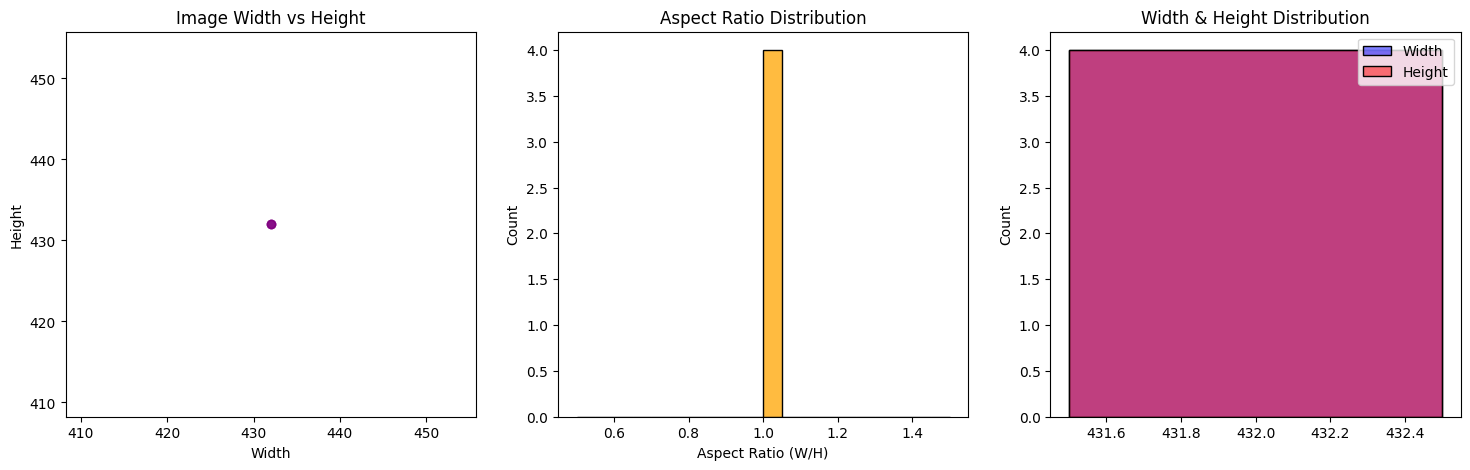

In [7]:
import os
import glob
import random
import yaml
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from tqdm import tqdm  # For progress bars

# --- CONFIGURATION (Copied from DwlyWTz90U0J to make it self-contained) ---
DATASET_DIR = "balanced_dataset"
SPLIT = "train"

# Paths
images_dir = os.path.join(DATASET_DIR, SPLIT, "images")
labels_dir = os.path.join(DATASET_DIR, SPLIT, "labels")
yaml_path = os.path.join(DATASET_DIR, "data.yaml")

# Load Class Names
if os.path.exists(yaml_path):
    with open(yaml_path, 'r') as f:
        data_yaml = yaml.safe_load(f)
        class_names = data_yaml.get('names', [])
else:
    class_names = {} # Fallback if no yaml found

print(f"Analyzing dataset at: {images_dir}")

def plot_image_sizes():
    img_files = glob.glob(os.path.join(images_dir, "*"))[:500] # Limit to 500 images for speed
    widths = []
    heights = []
    aspect_ratios = []

    print("Analyzing image sizes...")
    for img_file in tqdm(img_files):
        # Open efficiently without loading pixel data
        with Image.open(img_file) as img:
            w, h = img.size
            widths.append(w)
            heights.append(h)
            aspect_ratios.append(w / h)

    # Plots
    fig, ax = plt.subplots(1, 3, figsize=(18, 5))

    # Width vs Height Scatter
    ax[0].scatter(widths, heights, alpha=0.5, color='purple')
    ax[0].set_title("Image Width vs Height")
    ax[0].set_xlabel("Width")
    ax[0].set_ylabel("Height")

    # Aspect Ratio Histogram
    sns.histplot(aspect_ratios, bins=20, ax=ax[1], color='orange')
    ax[1].set_title("Aspect Ratio Distribution")
    ax[1].set_xlabel("Aspect Ratio (W/H)")

    # Size Histogram
    sns.histplot(widths, color='blue', label='Width', ax=ax[2], kde=True)
    sns.histplot(heights, color='red', label='Height', ax=ax[2], kde=True)
    ax[2].set_title("Width & Height Distribution")
    ax[2].legend()

    plt.show()

plot_image_sizes()

Calculating pixel intensities (Sample 50)...


100%|██████████| 4/4 [00:00<00:00, 332.58it/s]


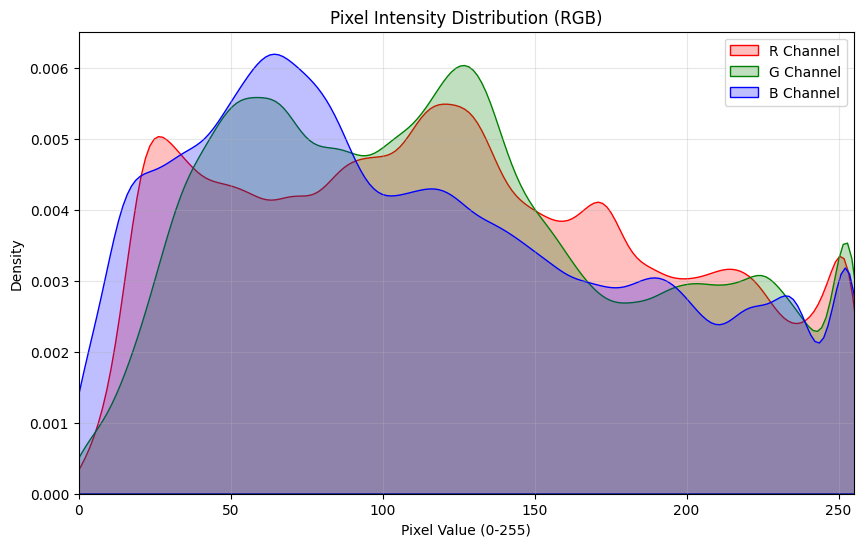

In [8]:
def plot_pixel_intensity():
    img_files = glob.glob(os.path.join(images_dir, "*"))
    if not img_files: return

    # Sample 50 images to save memory/time
    sample_files = random.sample(img_files, min(len(img_files), 50))

    pixel_values = []

    print("Calculating pixel intensities (Sample 50)...")
    for img_file in tqdm(sample_files):
        img = cv2.imread(img_file)
        if img is not None:
            # Convert to RGB and flatten
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            pixel_values.append(img.reshape(-1, 3))

    # Concatenate all pixels
    all_pixels = np.vstack(pixel_values)

    # Plot
    plt.figure(figsize=(10, 6))
    colors = ['r', 'g', 'b']
    for i, color in enumerate(colors):
        sns.kdeplot(all_pixels[:, i], color=color, fill=True, label=color.upper() + " Channel")

    plt.title("Pixel Intensity Distribution (RGB)")
    plt.xlabel("Pixel Value (0-255)")
    plt.xlim(0, 255)
    plt.legend()
    plt.grid(alpha=0.3)
    plt.show()

plot_pixel_intensity()

In [9]:
import os
import glob
import cv2
import shutil
from tqdm import tqdm

# CONFIGURATION
DATASET_DIR = "balanced_dataset"
SPLITS = ['train', 'valid', 'test']
QUARANTINE_DIR = "quarantine_data"  # Where bad files go

# Create quarantine folder
if not os.path.exists(QUARANTINE_DIR):
    os.makedirs(QUARANTINE_DIR)

def move_to_quarantine(img_path, lbl_path, reason):
    """Moves bad files out of the dataset."""
    print(f"⚠️ Removing {os.path.basename(img_path)}: {reason}")

    # Create subfolder in quarantine
    dest = os.path.join(QUARANTINE_DIR, reason)
    os.makedirs(dest, exist_ok=True)

    # Move Image
    if os.path.exists(img_path):
        shutil.move(img_path, os.path.join(dest, os.path.basename(img_path)))

    # Move Label
    if lbl_path and os.path.exists(lbl_path):
        shutil.move(lbl_path, os.path.join(dest, os.path.basename(lbl_path)))

def clean_dataset():
    for split in SPLITS:
        img_dir = os.path.join(DATASET_DIR, split, 'images')
        lbl_dir = os.path.join(DATASET_DIR, split, 'labels')

        if not os.path.exists(img_dir): continue

        img_files = glob.glob(os.path.join(img_dir, "*"))

        print(f"Scanning {split} set ({len(img_files)} files)...")

        for img_path in tqdm(img_files):
            # 1. Define Label Path
            basename = os.path.splitext(os.path.basename(img_path))[0]
            lbl_path = os.path.join(lbl_dir, basename + ".txt")

            # 2. Check for Corrupt Image
            try:
                img = cv2.imread(img_path)
                if img is None:
                    move_to_quarantine(img_path, lbl_path, "corrupt_image")
                    continue
            except Exception:
                move_to_quarantine(img_path, lbl_path, "corrupt_image")
                continue

            # 3. Check Label Validity
            if os.path.exists(lbl_path):
                with open(lbl_path, 'r') as f:
                    lines = f.readlines()

                # If file exists but is empty, it's a background image (Valid in YOLO)
                if not lines:
                    continue

                valid_label = True
                for line in lines:
                    parts = list(map(float, line.strip().split()))

                    # Check 1: Format length (Class + 4 coords minimum)
                    if len(parts) < 5:
                        valid_label = False
                        break

                    # Check 2: Normalization (Coordinates must be between 0 and 1)
                    # parts[1] = x_center, parts[2] = y_center, parts[3] = width, parts[4] = height
                    if any(c > 1.0 or c < 0.0 for c in parts[1:5]):
                        valid_label = False
                        print(f"Non-normalized coords found in {basename}")
                        break

                if not valid_label:
                    move_to_quarantine(img_path, lbl_path, "invalid_coordinates")

clean_dataset()
print("\n✅ Cleaning complete. Check 'quarantine_data' folder for removed files.")

Scanning train set (4 files)...


100%|██████████| 4/4 [00:00<00:00, 287.70it/s]


Scanning test set (1 files)...


100%|██████████| 1/1 [00:00<00:00, 278.75it/s]


✅ Cleaning complete. Check 'quarantine_data' folder for removed files.


In [19]:
import os
import yaml
!pip install ultralytics
from ultralytics import YOLO

# 1. Load the Segmentation Model (Small Version)
# 's-seg' is faster than 'm' (Medium) but slower than 'n' (Nano).
model = YOLO('yolo11s-seg.pt')

# 2. Define Speed-Optimized Arguments
train_args = {
    "data": "balanced_dataset/data.yaml",

    # --- TIME SAVERS (Goal: < 40 mins) ---
    "epochs": 10,           # Keep low for a quick test
    "imgsz": 416,           # Small image size drastically speeds up segmentation
    "batch": 4,             # Kept safe for memory
    "workers": 8,           # High workers to process polygon masks faster
    "cache": True,          # Essential for speed
    "patience": 5,          # Stop early if not learning
    "val": False,           # Disable validation

    # --- IMBALANCE HANDLING (Lightweight) ---
    "mixup": 0.1,
    "mosaic": 1.0,

    # --- SPECIFIC TO SEGMENTATION ---
    "overlap_mask": True,   # Handle overlapping objects (common in COCO)
    "mask_ratio": 4,        # Downsample masks to speed up training
}

# 3. Train
print("Starting Segmentation Training (YOLO11s-seg)...")
model.train(**train_args)

Starting Segmentation Training (YOLO11s-seg)...
Ultralytics 8.3.248 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=4, bgr=0.0, box=7.5, cache=True, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=balanced_dataset/data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=10, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=416, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.1, mode=train, model=yolo11s-seg.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=train7, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, 

ultralytics.utils.metrics.SegmentMetrics object with attributes:

ap_class_index: array([ 9, 21, 28, 30, 41, 43, 48])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7e8bdd753710>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)', 'Precision-Recall(M)', 'F1-Confidence(M)', 'Precision-Confidence(M)', 'Recall-Confidence(M)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,  

In [21]:
from ultralytics import YOLO
import os

# 1. Locate your trained model weights
# NOTE: If you ran training multiple times, this might be inside "train2", "train3", etc.
# Check your file explorer on the left under "runs/segment/"
weights_path = 'runs/segment/train7/weights/best.pt'

if not os.path.exists(weights_path):
    print(f"⚠️ Could not find weights at {weights_path}. Please check the 'runs' folder.")
else:
    print(f"✅ Loading weights from: {weights_path}")
    model = YOLO(weights_path)

✅ Loading weights from: runs/segment/train7/weights/best.pt


In [22]:
# 2. Run Evaluation
print("Evaluating on Test Set...")
metrics = model.val(
    data="balanced_dataset/data.yaml",
    split="test",       # Use the unseen 'test' set
    imgsz=416,          # MUST match the size you used for training
    batch=4,
    conf=0.25,          # Confidence threshold (only count predictions > 25% sure)
    iou=0.6             # Intersection over Union threshold
)

# 3. Print Key Results
print("\n--- SEGMENTATION RESULTS ---")
print(f"Mask mAP50-95: {metrics.seg.map:.4f} (Main Metric)")
print(f"Mask mAP50:    {metrics.seg.map50:.4f}")

print("\n--- BOX RESULTS ---")
print(f"Box mAP50-95:  {metrics.box.map:.4f}")
print(f"Box mAP50:     {metrics.box.map50:.4f}")

Evaluating on Test Set...
Ultralytics 8.3.248 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLO11s-seg summary (fused): 113 layers, 10,097,002 parameters, 0 gradients, 33.0 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 636.7±0.0 MB/s, size: 27.7 KB)
val: Scanning /content/balanced_dataset/test/labels... 1 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 1/1 498.8it/s 0.0s
val: New cache created: /content/balanced_dataset/test/labels.cache
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 1/1 9.7it/s 0.1s
                   all          1          3       0.25       0.25      0.188      0.188       0.25       0.25      0.188      0.169
               hot dog          1          2        0.5        0.5      0.375      0.375        0.5        0.5      0.375      0.338
              sandwich          1          1          0          0          0          0  


image 1/1 /content/balanced_dataset/test/images/000000000321_jpg.rf.ca3e75ab466ecaedb377d11f742d5843.jpg: 416x416 1 cat, 2 giraffes, 2 hot dogs, 1 sandwich, 15.5ms
Speed: 1.5ms preprocess, 15.5ms inference, 12.4ms postprocess per image at shape (1, 3, 416, 416)


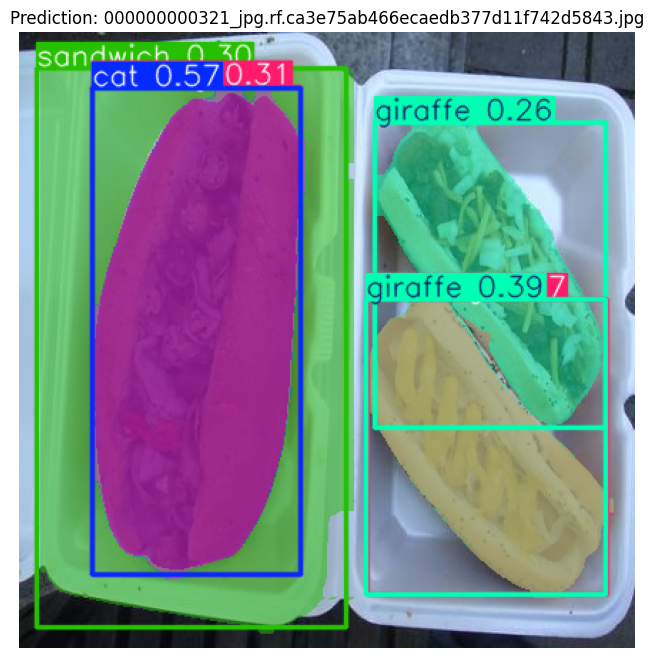

In [24]:
import matplotlib.pyplot as plt
import glob
import random
import cv2
import os # Added os import as it was used in title

def predict_and_plot():
    # Get images from the test set
    test_images = glob.glob("balanced_dataset/test/images/*")

    if not test_images:
        print("No images found in test folder.")
        return

    # Pick up to 3 random images, or fewer if not enough are available
    num_samples_to_plot = min(len(test_images), 3)
    samples = random.sample(test_images, num_samples_to_plot)

    for img_path in samples:
        # Run inference
        results = model.predict(
            source=img_path,
            conf=0.25,      # Show objects with >25% confidence
            imgsz=416,
            save=False      # Don't save to disk, just keep in memory
        )

        # Plot result
        for result in results:
            # result.plot() creates a numpy array with the masks drawn
            img_with_masks = result.plot()

            # Convert BGR (OpenCV) to RGB (Matplotlib)
            img_rgb = cv2.cvtColor(img_with_masks, cv2.COLOR_BGR2RGB)

            plt.figure(figsize=(10, 8))
            plt.imshow(img_rgb)
            plt.axis('off')
            plt.title(f"Prediction: {os.path.basename(img_path)}")
            plt.show()

predict_and_plot()

✅ Found latest segmentation results in: runs/segment/train7

--- Displaying results.png ---


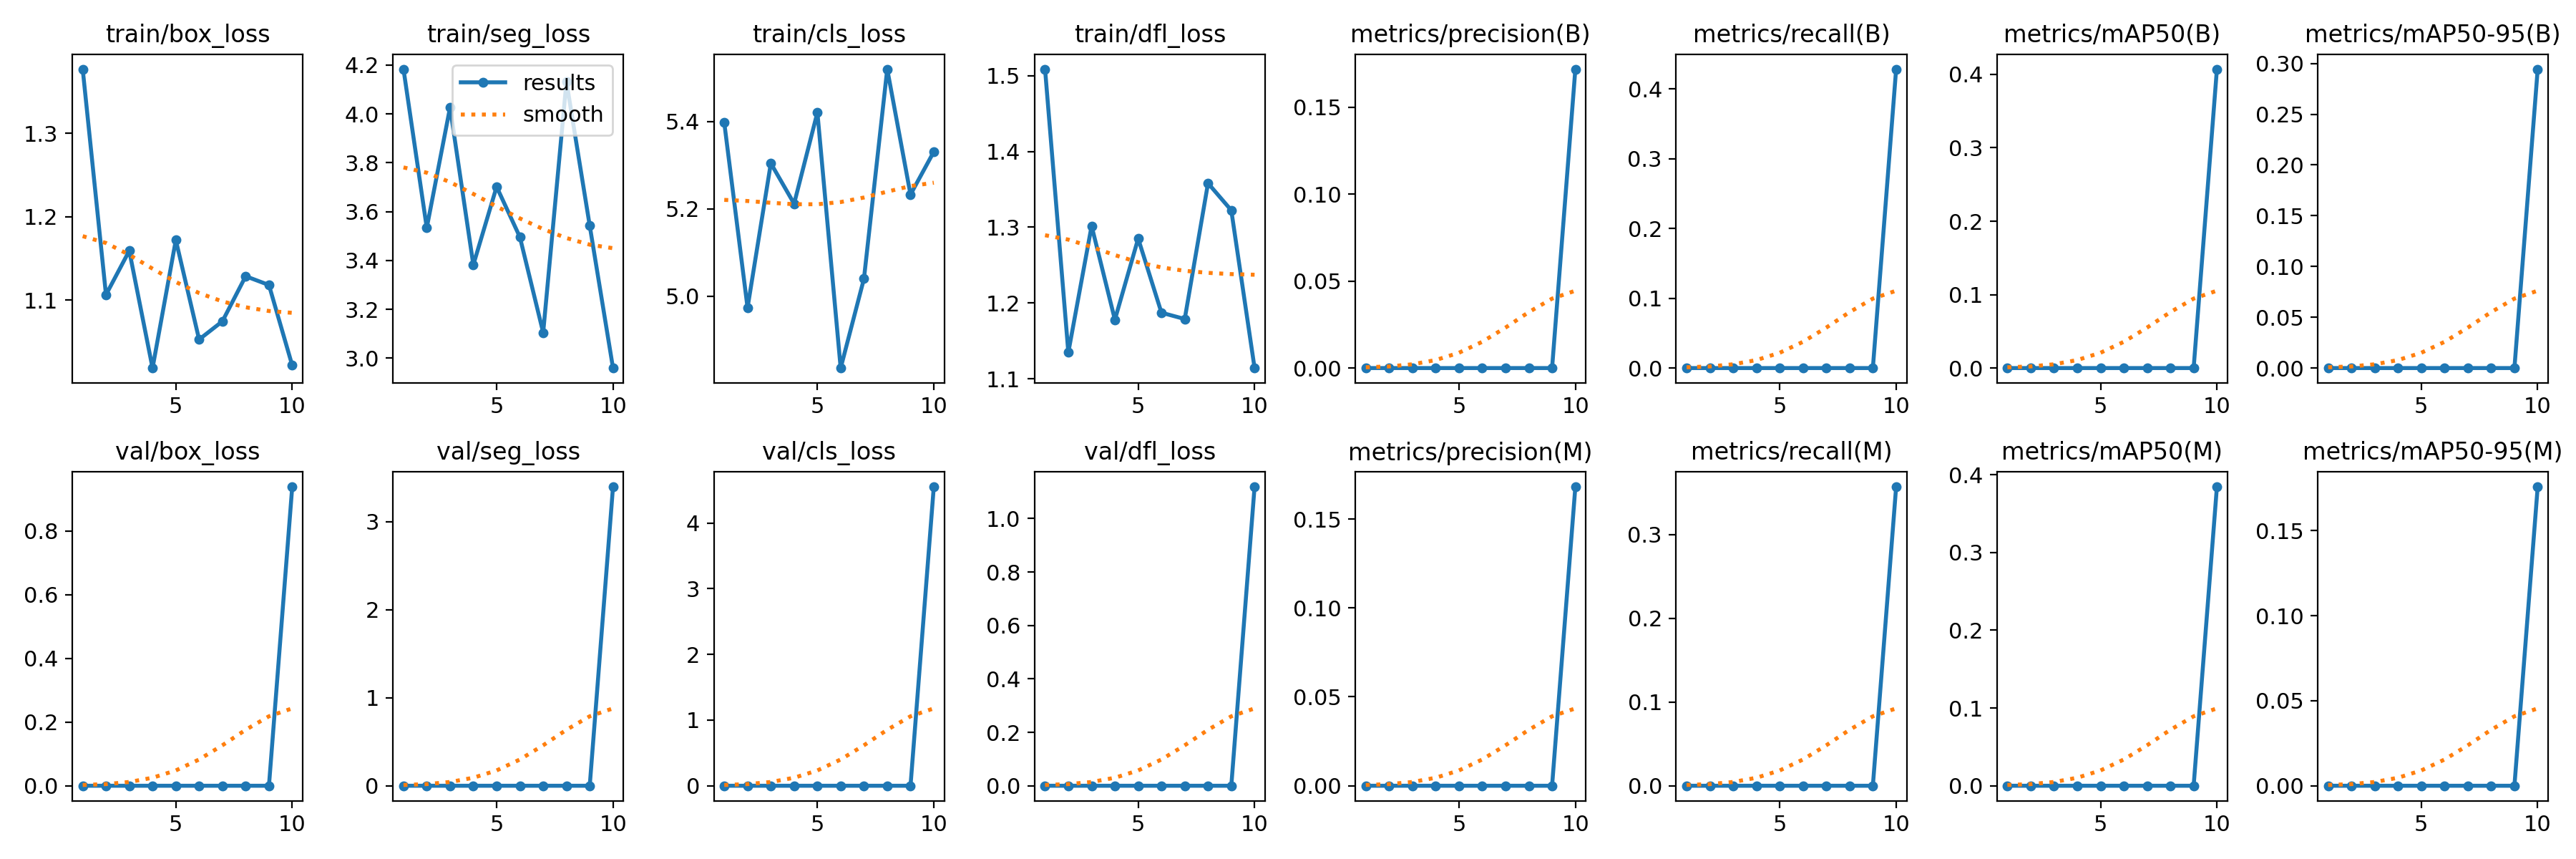


--- Displaying confusion_matrix.png ---


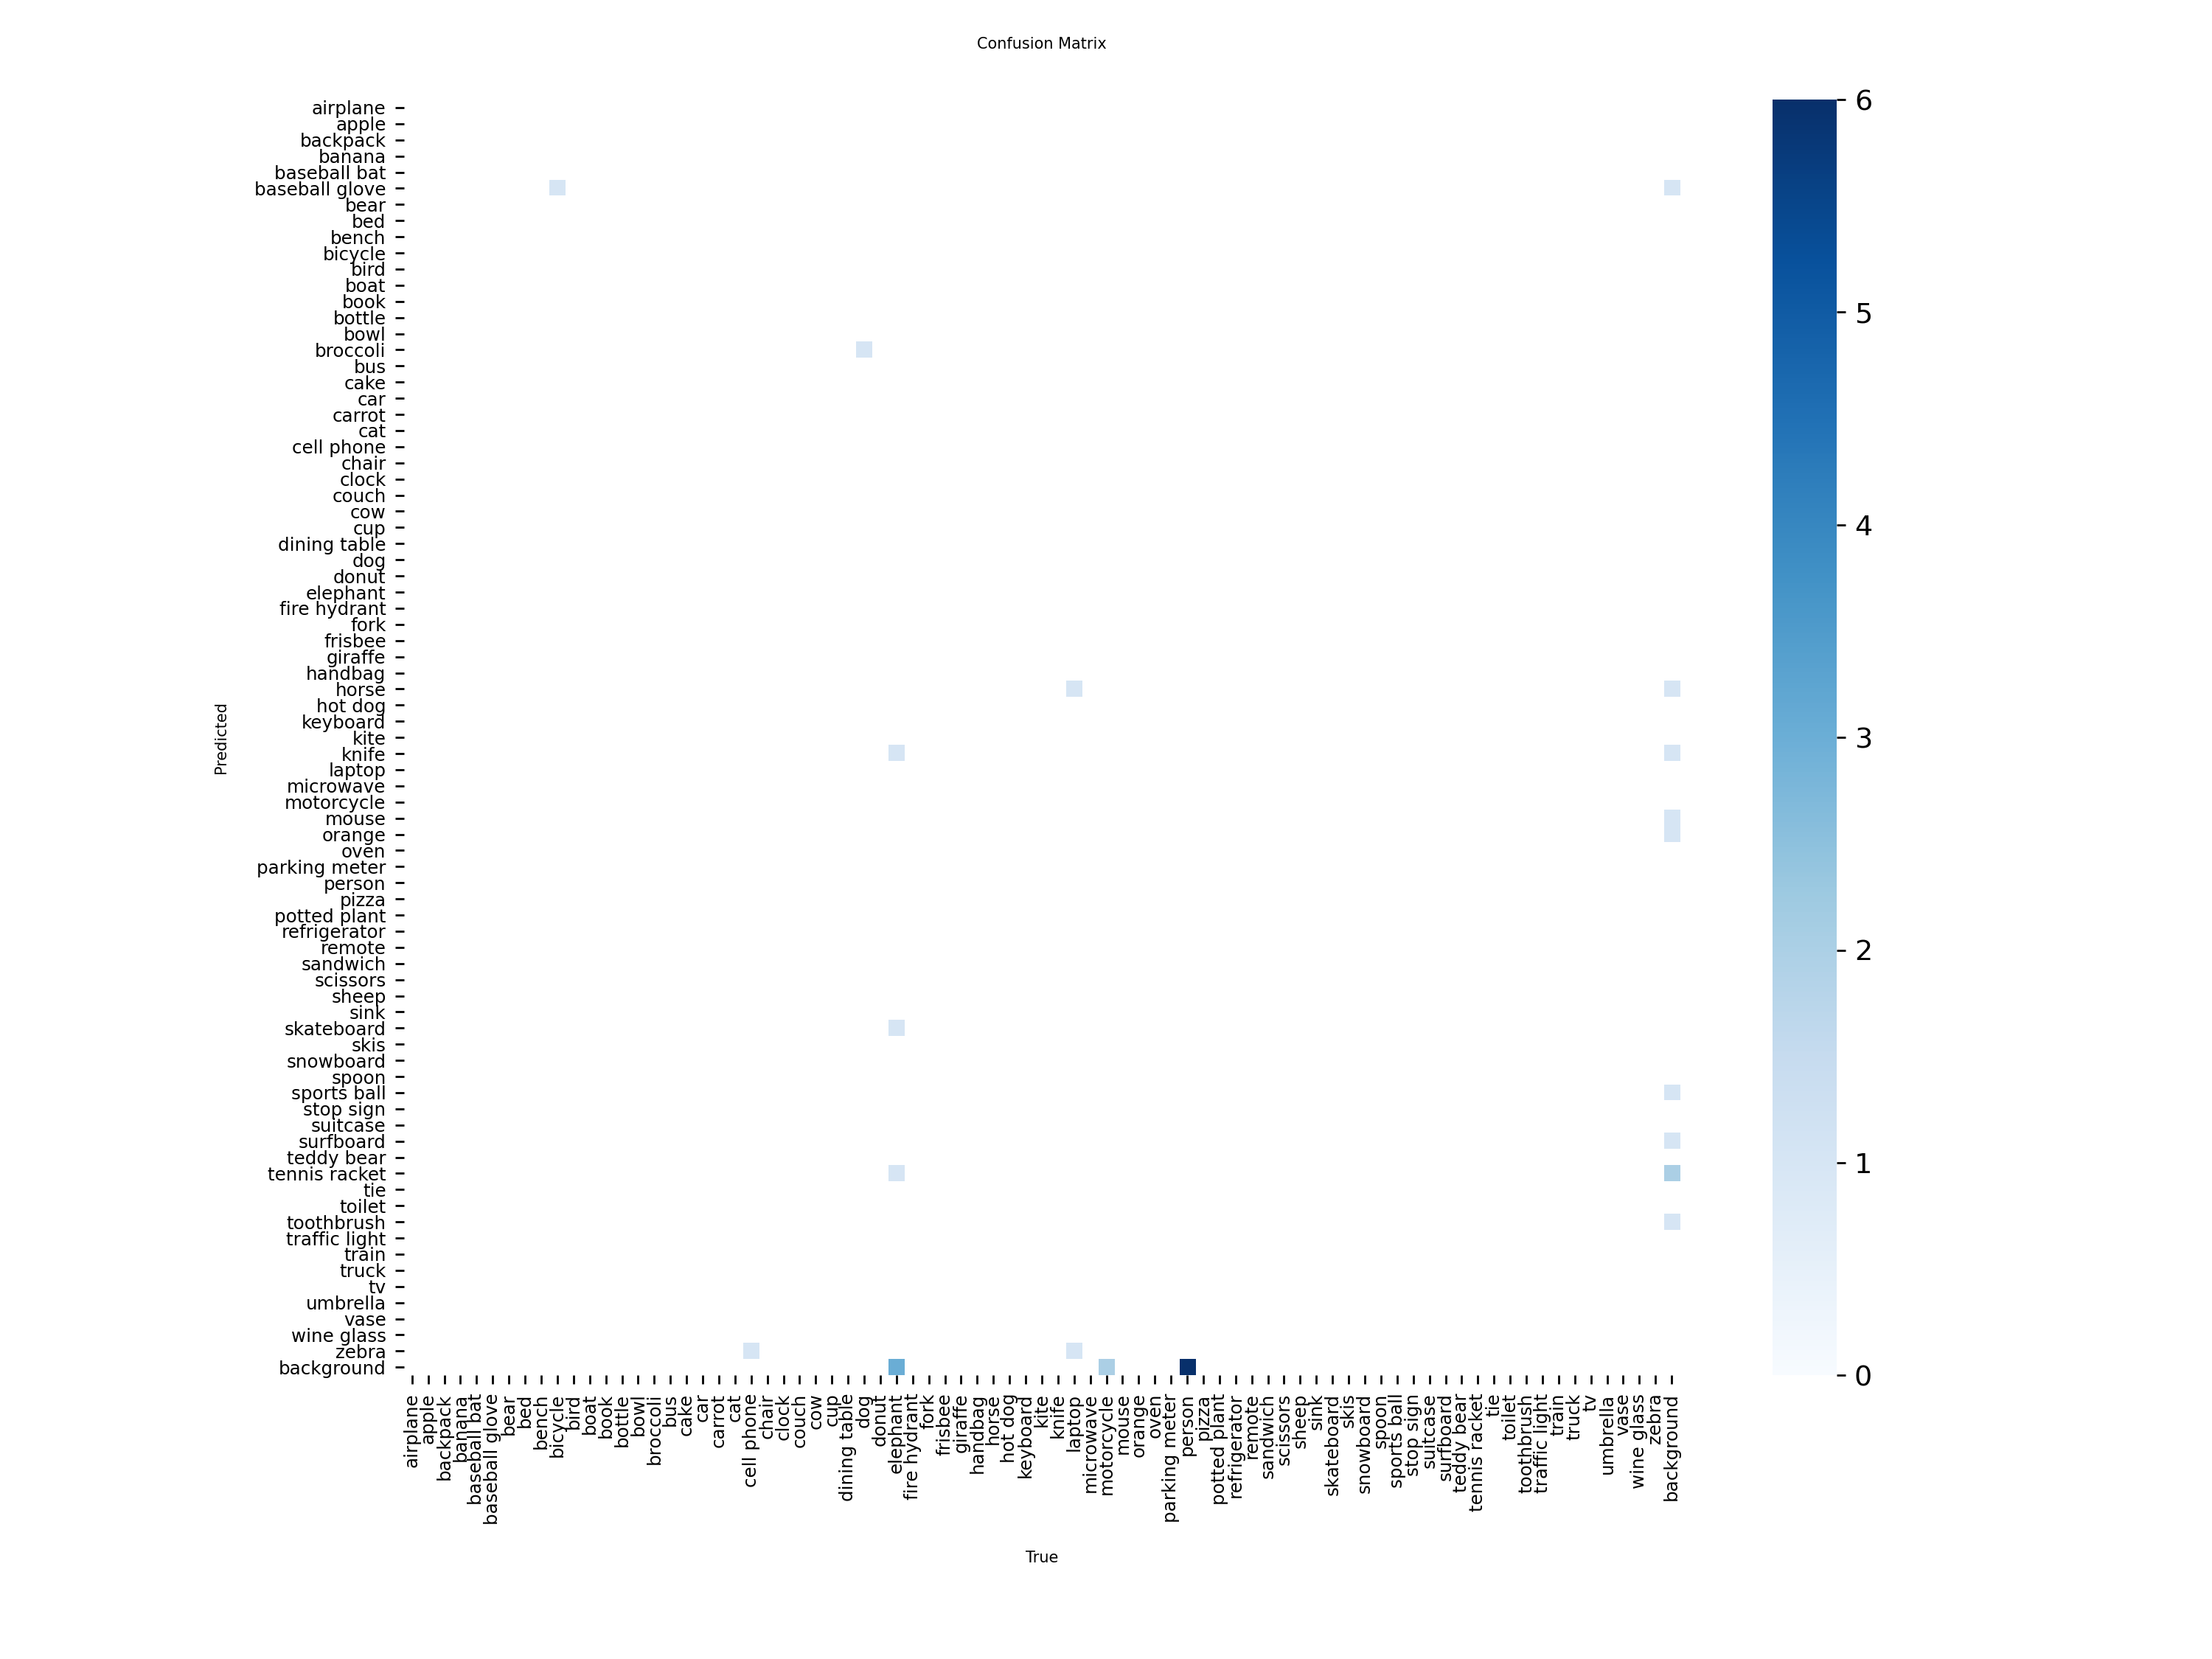

⚠️ F1_curve.png not found yet (training might still be in progress).

--- Displaying val_batch0_labels.jpg ---


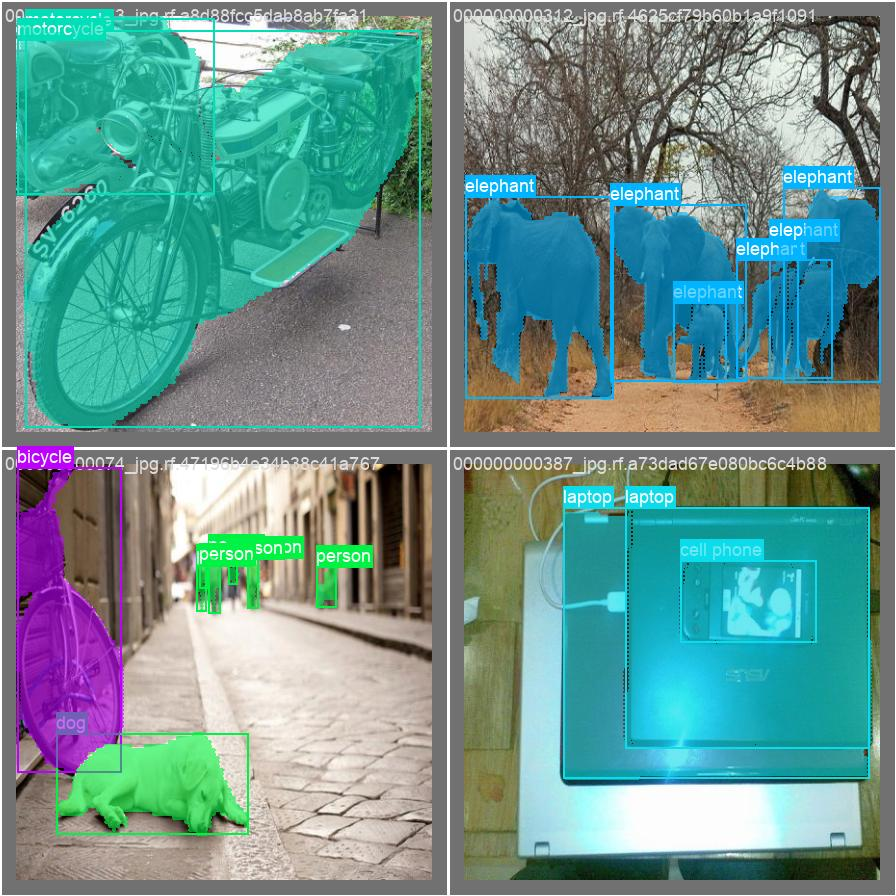


--- Displaying val_batch0_pred.jpg ---


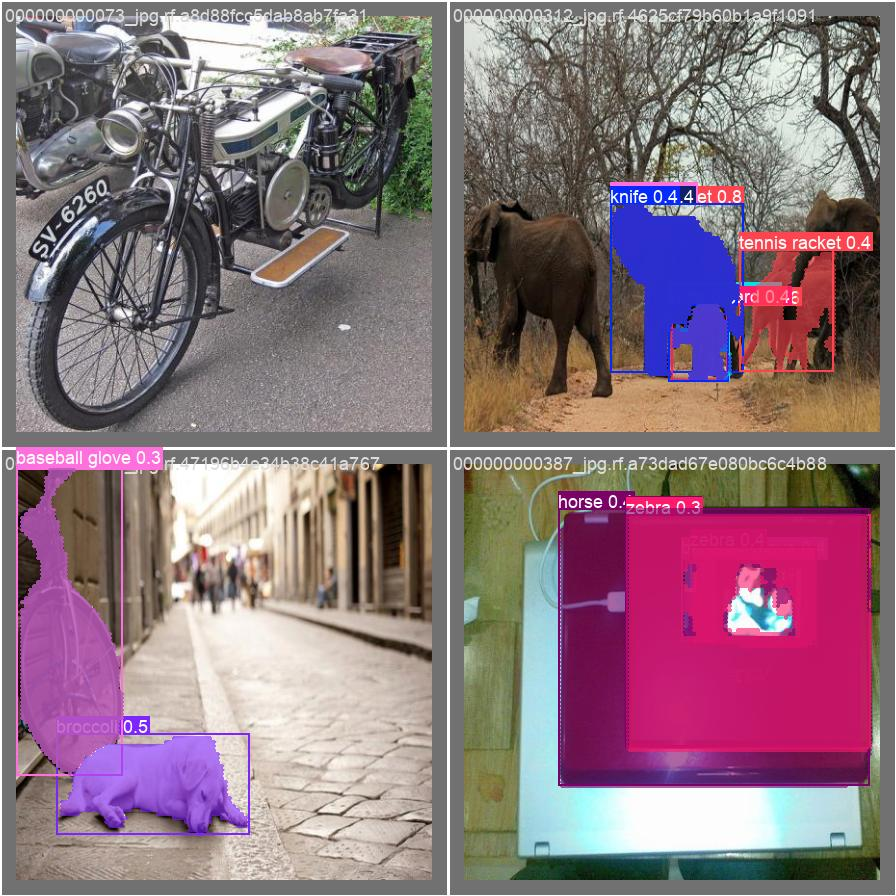

In [31]:
import os
from pathlib import Path
from IPython.display import Image, display

# 1. Target the 'segment' directory based on your screenshot
base_path = Path("runs/segment")

def get_latest_segmentation_run(path):
    if not path.exists():
        return None

    # Filter for folders that start with 'train'
    runs = [d for d in path.iterdir() if d.is_dir() and d.name.startswith('train')]

    if not runs:
        return None

    # Find the one with the highest number (e.g., train7)
    # This sorts 'train', 'train2', ..., 'train7' correctly
    latest_run = max(runs, key=lambda x: int(x.name.replace('train', '') or 0))
    return latest_run

latest_run = get_latest_segmentation_run(base_path)

if latest_run:
    print(f"✅ Found latest segmentation results in: {latest_run}")

    # Segmentation specific plots
    plots = [
        "results.png",                # Accuracy and Loss curves
        "confusion_matrix.png",       # Class accuracy
        "F1_curve.png",              # F1 Score
        "val_batch0_labels.jpg",      # Ground Truth masks
        "val_batch0_pred.jpg"         # Predicted masks
    ]

    for plot in plots:
        plot_path = latest_run / plot
        if plot_path.exists():
            print(f"\n--- Displaying {plot} ---")
            display(Image(filename=str(plot_path), width=800))
        else:
            print(f"⚠️ {plot} not found yet (training might still be in progress).")
else:
    print("❌ Could not find a 'train' folder inside 'runs/segment'.")